# CSE 482 Project by Andres Columna
## Predicting stock price fluctuations from Twitter Sentiment data

# table of contents

1. <a href="#collection"> Collection  </a>
2. <a href="#preprocessing"> Preprocessing </a>
3. <a href="#modeling"> Modeling </a>

* Social media platforms such as Twitter have become a popular data source for many big data applications, from event monitoring (e.g., detecting earthquakes) to forecasting applications (e.g., predicting disease outbreak). The goal of this project is to leverage the social media data for an event monitoring or forecasting application.


* For example, consider the stock market prediction task. Given a collection of real-time tweets, the goal is to provide a price forecast for a particular stock based on users sentiment expressed in their tweets

<span id="collection"> Preprocessing </span>
# Collection
### 1. Get Twitter data

## Get data Twitter Json Data from P-Tan-Repository

```bash
sftp columnaa@arctic.cse.msu.edu
cd /user/research/ptan/data/Twitter/
ls 1604* # all files available on the month of April 2016
# $ 160401000522  160401212357  160401220219  160402000529 160403000350  160404000118
# $ 160405000304  160406000412	160406192326  160409162410
ls 1603* # all files available on month of March 2016

# download each tweet file individually
# example:
get 160401212357 # ~15 GB

# afterwards there are often multiple files for the same day. Concatenate all files pertaining to one day into one file
cat 160401* > april-1-2016.json
```

---

![files.png](./pictures/files.png)
![size.png](./pictures/file_size.png)

##### The limiting factor was the space on my local hard drive. 72.5 GB was my limit. This gave me a maximum of 7 data points. Also it took on average 25 minutes to `get` a file through SFTP, and half the time the connection would die half-way through the download

In [2]:
import json
import pandas

<span id="preprocessing"></span>
# Preprocessing
## Preprocess raw twitter file

1. Only select tweets that mention the brands **Nike, Adidas, Reebok, Under Armour, or Puma.**
2. From the JSON fields, the only relevant columns to select are `['created_at','favorite_count','retweet_count', 'verified','name','id','followers_count']`

In [442]:
fields = ['created_at','favorite_count','retweet_count']
secondary_user_fields = ['verified','name','id','followers_count']
brands = ['nike','adidas','reebok','under armour','puma']

rows = []

filename = "march-30-2016"
with open("rawdata/" + filename + ".json") as file:
    for line in file:
        
        if line == '\n':
            continue
        try:
            row = json.loads(line)

            if 'id' not in row:
                continue

            text = row['text'].lower()

            if any(brand in text for brand in brands):


                d = {field : row[field] for field in fields}
                d['text'] = text

                for field in secondary_user_fields:
                    d['user-' + field] = row['user'][field]

                rows.append(d)
        except:
            pass
            
data = pd.DataFrame(rows)
data.to_excel(filename + '.xlsx')
data.head()

,created_at,favorite_count,retweet_count,text,user-followers_count,user-id,user-name,user-verified
0,Wed Mar 30 04:02:34 +0000 2016,0,0,damn no wonder adidas lv was pack cause they r...,309,219625957,Brown Iverson,False
1,Wed Mar 30 04:04:07 +0000 2016,0,0,@tahmohpenikett @htc @htcusa @webstervictor i ...,7,3496892840,Shana Karlsen,False
2,Wed Mar 30 04:04:36 +0000 2016,0,0,another great workout with nike! #nrc https://...,82,330789656,Blackwrath,False
3,Wed Mar 30 04:06:59 +0000 2016,0,0,@dee_man_8 @carlsenju trueeeee carl you might ...,859,530866421,び Sears び,False
4,Wed Mar 30 04:07:03 +0000 2016,0,0,https://t.co/92ulbng17b #aliens #reebok #sneak...,1261,33005796,Christian D. Bruun,False


* Making this script work took 8+ hours of debugging. Raw json string could only be read by Python JSON module by specifying the string was raw i.e., r"This is a string.". However, there is no way it seems to 'convert' a string to 'raw'. The 'r' prefix really tells the python interpreter how to read the string, but it doesn't modify the string. It just tells the interpreter to treat, say, \n as two characters \ and n, instead of as a newline character. After much tinkering, it seems as if ignoring certain lines that have problematic characters allows JSONmodule to parse the string into a Python Dictionary object. 

In [ ]:
# script to get all relevant fields
fields = ['id', 'text','favorite_count','retweet_count','timestamp_ms']
secondary_user_fields = ['verified','name','id','followers_count']
d = {field : row[field] for field in fields}
for field in secondary_user_fields:
    d['user-' + field] = row['user'][field]

#### Format of a raw JSON twitter string

In [113]:
x

'{"created_at":"Mon Apr 04 04:03:32 +0000 2016","id":716838589334740992,"id_str":"716838589334740992","text":"Nothing is more frustrating than not being able to fall asleep \ud83d\ude44","source":"<a href="http:\\/\\/twitter.com\\/download\\/iphone" rel="nofollow">Twitter for iPhone<\\/a>","truncated":false,"in_reply_to_status_id":null,"in_reply_to_status_id_str":null,"in_reply_to_user_id":null,"in_reply_to_user_id_str":null,"in_reply_to_screen_name":null,"user":{"id":2463188847,"id_str":"2463188847","name":"Meg","screen_name":"mcdingwall","location":null,"url":null,"description":"strength & faith  ll ECU 19\'","protected":false,"verified":false,"followers_count":514,"friends_count":456,"listed_count":2,"favourites_count":2769,"statuses_count":4346,"created_at":"Sat Apr 05 20:21:08 +0000 2014","utc_offset":-14400,"time_zone":"Eastern Time (US & Canada)","geo_enabled":true,"lang":"en","contributors_enabled":false,"is_translator":false,"profile_background_color":"C0DEED","profile_backgro

In [76]:
json.loads(x)

{'created_at': 'Mon Apr 04 04:03:32 +0000 2016',
 'id': 716838589334740992,
 'id_str': '716838589334740992',
 'text': 'Nothing is more frustrating than not being able to fall asleep 🙄',
 'source': '<a href="http://twitter.com/download/iphone" rel="nofollow">Twitter for iPhone</a>',
 'truncated': False,
 'in_reply_to_status_id': None,
 'in_reply_to_status_id_str': None,
 'in_reply_to_user_id': None,
 'in_reply_to_user_id_str': None,
 'in_reply_to_screen_name': None,
 'user': {'id': 2463188847,
  'id_str': '2463188847',
  'name': 'Meg',
  'screen_name': 'mcdingwall',
  'location': None,
  'url': None,
  'description': "strength & faith  ll ECU 19'",
  'protected': False,
  'verified': False,
  'followers_count': 514,
  'friends_count': 456,
  'listed_count': 2,
  'favourites_count': 2769,
  'statuses_count': 4346,
  'created_at': 'Sat Apr 05 20:21:08 +0000 2014',
  'utc_offset': -14400,
  'time_zone': 'Eastern Time (US & Canada)',
  'geo_enabled': True,
  'lang': 'en',
  'contributors_en

In [23]:
all_file_names = ['april-1-2016-1.xlsx',
 'april-4-2016.xlsx',
 'march-30-2016.xlsx',
 'april-2-2016.xlsx',
 'april-5-2016-1.xlsx',
 'march-31-2016.xlsx']

In [ ]:
# Files have been whittled down from 75 GB to 1 MB of tweets that pertain to sports brands

In [444]:
# consolidate tweets from all days gathered (March 29-April 6) that mention the relevant sports brands
all_data_frames = [pd.read_excel(filename) for filename in all_file_names]

In [28]:
df = pd.concat(all_data_frames)

In [443]:
all_data[all_data['favorite_count'] != 0].head() # Tweet Favorited data not available?

,created_at,favorite_count,retweet_count,text,user-followers_count,user-id,user-name,user-verified


In [590]:
all_data.to_csv('sports_tweets.csv')

## 9090 Tweets

In [592]:
all_data.shape

(9090, 8)

In [487]:
all_data.head()

,created_at,favorite_count,retweet_count,text,user-followers_count,user-id,user-name,user-verified
0,Fri Apr 01 04:07:27 +0000 2016,0,0,nike https://t.co/oqqzkguwxg,123,3286850736,halie riviera,False
1,Fri Apr 01 04:08:03 +0000 2016,0,0,@puma @kyliejenner get a real job,171,3673126657,Renee Kelly,False
2,Fri Apr 01 04:08:20 +0000 2016,0,0,@adidasus is coming out with some 🔥🔥🔥 shoes la...,903,2345323497,Riley Taylor,False
3,Fri Apr 01 04:09:08 +0000 2016,0,0,nike https://t.co/9coycuqs2x,1634,60183705,B,False
4,Fri Apr 01 04:09:19 +0000 2016,0,0,"@coleman_jordan call nike. send them to them, ...",296,1455815322,mw,False


### Example tweet

In [445]:
df.loc[873]['text']

'manuel: nike will be official on august 1. proud of relationship school has had with adidas.'

In [446]:
# tweets sorted by follower-count of sender.
df2.sort_values(by=['user-followers_count'], ascending=False).head()

,created_at,favorite_count,hype-created,retweet_count,text,user-followers_count,user-id,user-name,user-verified
8073,2016-03-31,0,42.490923,0,love and basketball shawnie easton 2.0 #nikedo...,3035846,256881576,Gabrielle Union,True
1679,2016-04-04,0,36.347803,0,"qué bueno que ganó roman reigns, así @verockst...",1257467,43566131,Jimena Sanchez,True
9052,2016-04-01,0,37.910402,0,i loved vachetta tan leather on kicks until it...,677002,15097566,Nice Kicks,True
6472,2016-04-05,0,34.424298,0,world team adds udoka azubuike (nigeria/potter...,576474,17049258,USA Basketball,True
6349,2016-04-05,0,34.424208,0,don't miss nike news profile of usa @nikehoops...,576453,17049258,USA Basketball,True


In [41]:
!ls 

Project 482.ipynb   april-3-2016.xlsx   main.py             rawdata
april-1-2016-1.xlsx april-4-2016.xlsx   march-30-2016.xlsx  venv
april-2-2016.xlsx   april-5-2016-1.xlsx march-31-2016.xlsx


In [61]:
from statistics import mean

### Sentiment Analysis using TextBlob

##### Example of positive sentence.

In [452]:
import textblob
text = "Nike is the best company Ever"
blob = TextBlob(text)

for sentence in blob.sentences:
    print(sentence.sentiment.polarity)

1.0


#### Example of negative sentence

In [455]:
text = "Puma is the worst company ever."

for sentence in TextBlob(text).sentences:
    print(sentence.sentiment.polarity)

-1.0


##### Example of ambivalent sentence.

In [456]:
text = "Reebok is alright."

for sentence in TextBlob(text).sentences:
    print(sentence.sentiment.polarity)

0.0


### Measuring the influence of a tweet

1. get mean sentiment of all sentences in tweet.
2. multiply the sentiment of a tweet by the number of followers that account has, to get 'hype', a new ad hoc measure I've coined for convenience
3. 'Hype' is multiplied by 20 if its from a verified account. This is because being endorsed by a public figure is more influential than an anonymous account. That's why sports companies pay professional athletes to wear their products.
4. Modulate the sentiment by finding the log(sentiment, 1.5). This step is more art than science: a tweet by someone with 1000 followers is not 1000x more influential than one from a 5-follower account. In my opinion it's about 5x more influential. Log(x, 1.5) achieves this. Also, it's not all about influence created, but capturing enthusiasm for a brand among lay people.


This script also makes a new column in every row titled mean sentiment.

In [475]:
dataList = df.to_dict('records')
from statistics import mean


def scoringFunction(dic, sentiment):
    """given a raw sentiment, it's 'normalizes' it according to an algorithm based on intuition"""
    if sentiment == 0:
        sentiment = .1 # a neutral mention is actually positive in terms of the stock market. Thus include it
    followers = int(dic['user-followers_count']) + 1
    verified = dic['user-verified']
   
    score = (followers * sentiment) + 1
    if verified:
        score *= 20 # being verified makes a tweet more authoritative, thus more influence
    if score < 0: # log of negative number is undefined
        return -1 * log(abs(score), 1.5)
    else:
        return log(score,1.5)
    
# 
def addSentiment(dataList):
    '''Adds sentiment score to each data row'''
    for row in dataList:
        x = [sentence.sentiment.polarity for sentence in TextBlob(str(row['text'])).sentences]
        row['hype-created'] = scoringFunction(row, mean(x))
        
addSentiment(dataList)
df2 = pd.DataFrame(dataList)
df2
df2.sort_values(by=['user-followers_count'], ascending=False).head()

,created_at,favorite_count,hype-created,retweet_count,text,user-followers_count,user-id,user-name,user-verified
8073,Thu Mar 31 17:50:56 +0000 2016,0,42.490923,0,love and basketball shawnie easton 2.0 #nikedo...,3035846,256881576,Gabrielle Union,True
1679,Mon Apr 04 05:22:47 +0000 2016,0,36.347803,0,"qué bueno que ganó roman reigns, así @verockst...",1257467,43566131,Jimena Sanchez,True
9052,Fri Apr 01 03:35:23 +0000 2016,0,37.910402,0,i loved vachetta tan leather on kicks until it...,677002,15097566,Nice Kicks,True
6472,Tue Apr 05 17:37:02 +0000 2016,0,34.424298,0,world team adds udoka azubuike (nigeria/potter...,576474,17049258,USA Basketball,True
6349,Tue Apr 05 16:09:56 +0000 2016,0,34.424208,0,don't miss nike news profile of usa @nikehoops...,576453,17049258,USA Basketball,True


In [591]:
df2.to_csv('sports_tweets_with_sentiment.csv')

### Here we can see the most influential tweet achieves a hype of 42.49 by a verified account with 3 million followers.

#### The stock data's granularity is by date. Thus our tweet should match this as well. This script standardizes the format of the tweet date columns, removing time data. This is the format used by the Yahoo finance data we will be using later on.

In [476]:
dates = ['Mar 30','Mar 31','Apr 01','Apr 02','Apr 03','Apr 04','Apr 05','Apr 06']
new_dates = ['2016-03-30', '2016-03-31', '2016-04-01', '2016-04-02', '2016-04-03', '2016-04-04', '2016-04-05','2016-04-06']
dateDict = dict(zip(dates, new_dates))

In [478]:
for row in dataList:
    date = row['created_at']
    for d, val in dateDict.items():
        if d in date:
            row['created_at'] = val
            continue

In [479]:
df3 = pd.DataFrame(dataList)
df3.head()

,created_at,favorite_count,hype-created,retweet_count,text,user-followers_count,user-id,user-name,user-verified
0,2016-04-01,0,6.400686,0,nike https://t.co/oqqzkguwxg,123,3286850736,halie riviera,False
1,2016-04-01,0,8.796594,0,@puma @kyliejenner get a real job,171,3673126657,Renee Kelly,False
2,2016-04-01,0,11.135966,0,@adidasus is coming out with some 🔥🔥🔥 shoes la...,903,2345323497,Riley Taylor,False
3,2016-04-01,0,12.585326,0,nike https://t.co/9coycuqs2x,1634,60183705,B,False
4,2016-04-01,0,8.445271,0,"@coleman_jordan call nike. send them to them, ...",296,1455815322,mw,False


In [270]:
# remove two useless columns from the dataframe because they're all zero!
for row in dataList:
    row.pop('favorite_count')
    row.pop('retweet_count')

In [489]:
# make list of dictionaries into list of tuples because that's what sqlite expects as an argument for its executemany method
insertionList = [tuple(row.values()) for row in dataList]

## Make sqlite3 database of tweets

* the main purpose of this is that the 'group by' sql function makes what I'm trying to do very convenient (that is, group all tweets by date it was tweeted), and b, show proficiency in something I learned from class.

In [272]:
# insert all tweets into database

import sqlite3
conn = sqlite3.connect("proj482.db")
conn.execute("CREATE TABLE tweets (created_at text, tweet text ,user_followers_count int, user_id int, user_name text, user_verified text, hype_created real);")
conn.executemany("INSERT INTO tweets(created_at,tweet , user_followers_count, user_id, user_name, user_verified , hype_created ) VALUES (?,?,?,?,?,?,?);", insertionList)
conn.commit()


In [488]:
#run select statement

conn = sqlite3.connect("proj482.db")
query = """
select created_at, avg(hype_created)
from tweets
group by created_at;
"""
results = conn.execute(query)

for row in results:
    print(row)
    
conn.close()

('2016-03-30', 8.103674774790845)
('2016-03-31', 8.022228623004015)
('2016-04-01', 8.054773872194504)
('2016-04-02', 7.29405767115563)
('2016-04-03', 7.6848204194519605)
('2016-04-04', 8.538105684324735)
('2016-04-05', 7.886625640681083)
('2016-04-06', 8.035456456933693)


## Get historical stock data for all our chosen stocks from Yahoo Finance. Site: [link](https://finance.yahoo.com/quote/NKE/). Only get data for dates we managed to get dates from.

##### Nike

In [279]:
import pandas as pd
%matplotlib inline

nike_data = pd.read_csv('NKE.csv', header='infer' )
nike_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,61.580002,61.980000,61.250000,61.340000,58.988018,7899000
1,2016-03-29,61.259998,61.900002,61.250000,61.490002,59.132275,7837800
2,2016-03-30,61.770000,62.410000,61.770000,62.040001,59.661171,7859300
3,2016-03-31,61.990002,62.639999,61.310001,61.470001,59.113026,8257800
4,2016-04-01,61.220001,61.820000,61.150002,61.590000,59.228432,7555300
5,2016-04-04,61.730000,61.849998,59.419998,59.970001,57.670536,16523400
6,2016-04-05,59.619999,60.169998,59.439999,59.669998,57.382050,7554000
7,2016-04-06,59.599998,60.680000,59.189999,60.310001,57.997513,10201500


##### Adidas

In [297]:
adidas_data = pd.read_csv( 'ADS.DE.csv', header='infer' )
adidas_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-29,103.099998,103.349998,101.900002,102.400002,97.120506,624648
1,2016-03-30,102.900002,104.750000,102.750000,104.599998,99.207085,593457
2,2016-03-31,104.300003,104.699997,102.949997,103.000000,97.689575,562256
3,2016-04-01,102.300003,102.900002,101.150002,102.449997,97.167931,589447
4,2016-04-04,102.150002,103.949997,101.900002,103.849998,98.495750,512238
5,2016-04-05,102.599998,103.400002,102.400002,102.750000,97.452461,616977
6,2016-04-06,102.800003,104.150002,101.650002,104.099998,98.732849,514152


##### Under Armour

In [281]:
ua_data = pd.read_csv( 'UA.csv', header='infer' )
ua_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-28,40.582272,40.582272,40.582272,40.582272,40.582272,0
1,2016-03-29,40.582272,40.582272,40.582272,40.582272,40.582272,0
2,2016-03-30,41.187977,41.704315,41.178047,41.704315,41.704315,3700
3,2016-03-31,41.704315,41.704315,41.426289,41.426289,41.426289,600
4,2016-04-01,40.800724,40.800724,40.800724,40.800724,40.800724,100
5,2016-04-04,40.800724,40.800724,40.800724,40.800724,40.800724,0
6,2016-04-05,40.214878,41.734104,40.214878,40.800724,40.800724,1700
7,2016-04-06,41.058891,41.704315,40.770935,41.505726,41.505726,700


##### Puma

In [282]:
puma_data = pd.read_csv('PUM.DE.csv', header='infer')
puma_data

,Date,Open,High,Low,Close,Adj Close,Volume
0,2016-03-29,193.199997,193.500000,190.500000,193.449997,190.332138,1404
1,2016-03-30,194.699997,194.699997,190.600006,194.100006,190.971664,1166
2,2016-03-31,193.149994,194.699997,193.149994,194.050003,190.922470,1564
3,2016-04-01,193.500000,194.550003,192.500000,193.750000,190.627319,2359
4,2016-04-04,191.050003,194.500000,191.050003,194.100006,190.971664,1243
5,2016-04-05,190.850006,194.600006,190.300003,191.899994,188.807114,1186
6,2016-04-06,194.199997,194.199997,190.800003,191.300003,188.216812,1229


### Plot of Puma stock prices between 3/29/16 - 4/6/16

[Text(0,0.5,'Closing Price')]

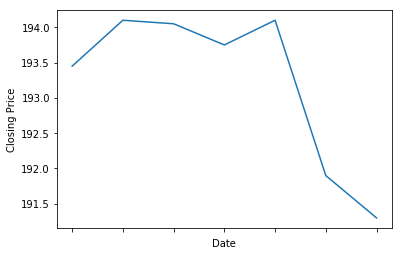

In [307]:
closingPrice = puma_data['Close']
closingPrice.index = puma_data['Date']
ax = closingPrice.plot(kind='line')
ax.set(ylabel='Closing Price')

In [298]:
puma_list = puma_data.to_dict('records')
ua_list = ua_data.to_dict('records')
nke_list = nike_data.to_dict('records')
adidas_list = adidas_data.to_dict('records')

### Remove the 3/29/16 data point so that all stock data can match dates

In [299]:
ua_list.pop(0)

{'Date': '2016-03-28',
 'Open': 40.582271999999996,
 'High': 40.582271999999996,
 'Low': 40.582271999999996,
 'Close': 40.582271999999996,
 'Adj Close': 40.582271999999996,
 'Volume': 0}

In [300]:
nke_list.pop(0)

{'Date': '2016-03-28',
 'Open': 61.580002,
 'High': 61.98,
 'Low': 61.25,
 'Close': 61.34,
 'Adj Close': 58.988018000000004,
 'Volume': 7899000}

##### Get all the stock prices and add them up by day. (All we care about is the aggregate price changes by day). The magnitude of price fluctuations in stocks is largely independent of it's stock price.

In [304]:
# Missing data to be filled in 
composite_list = []
for i in range(len(ua_list)):
    d = dict()
    d['date'] = ua_list[i]['Date']
    total = 0
    total += ua_list[i]['Close']
    total += puma_list[i]['Close']
    total += nke_list[i]['Close']
    total += adidas_list[i]['Close']
    d['closing price'] = total
    composite_list.append(d)

In [306]:
df3 = pd.DataFrame(composite_list)
df3

,closing price,date
0,397.922273,2016-03-29
1,402.444320,2016-03-30
2,399.946293,2016-03-31
3,398.590721,2016-04-01
4,398.720729,2016-04-04
5,395.120716,2016-04-05
6,397.215728,2016-04-06


* Price change from day before. Notice that data for 4/2/16 and 4/3/16 are missing. This is because these dates were Saturday and Sunday. Stock markets are closed on weekends. This means, sadly, that we will need to discard that twitter data for those days, since no corresponding stock market fluctuation data exists for those days.

* Also, Adidas and Puma being German companies and being traded on German stock platforms were not traded on 3/28/29, so we'll need to discard data for those dates on all data.

* lastly, since were interested in the price delta i.e. price difference between yesterday and today, the first date, 3/29/16, will not be appearing.

![size.png](./pictures/price_fluctuations.png)

In [330]:
N = Y.shape[0]
X = pd.DataFrame( Y[1:N].values, columns=['t-1'])
X.index = Y[1:].index
X.head()

,t-1
date,
2016-03-31,-2.498027
2016-04-01,-1.355572
2016-04-04,0.130008
2016-04-05,-3.600013
2016-04-06,2.095012


In [544]:
price_changes = [('2016-03-30', 4.522047),
('2016-03-31',-2.498027),
('2016-04-01',-1.355572),
('2016-04-04',0.130008),
('2016-04-05',-3.600013),
('2016-04-06',2.095012)]

In [537]:
# data from our previous query
query = """
select created_at, avg(hype_created)
from tweets
group by created_at;
"""

for i in results:
    print(i)

('2016-03-30', 8.903674774790845)
('2016-03-31', 8.022228623004015)
('2016-04-01', 8.054773872194504)
('2016-04-02', 7.29405767115563)
('2016-04-03', 7.6848204194519605)
('2016-04-04', 8.538105684324735)
('2016-04-05', 7.886625640681083)
('2016-04-06', 8.035456456933693)


#### also remove weekends

In [540]:
hype_averages_no_weekends = [('2016-03-30', 8.903674774790845),
('2016-03-31', 8.022228623004015),
('2016-04-01', 8.054773872194504),
('2016-04-04', 8.538105684324735),
('2016-04-05', 7.886625640681083),
('2016-04-06', 8.035456456933693)]

In [541]:
hype_averages_no_dates = [row[1] for row in hype_averages_no_weekends]

In [542]:
hype_averages_no_dates

[8.903674774790845,
 8.022228623004015,
 8.054773872194504,
 8.538105684324735,
 7.886625640681083,
 8.035456456933693]

In [548]:
price_hype = []
for i in range(len(hype_averages_no_dates)):
    lst = []
    lst.append(price_changes[i][0])
    lst.append(price_changes[i][1])
    lst.append(hype_averages_no_dates[i])
    price_hype.append(lst)

In [549]:
price_hype_df = pd.DataFrame(price_hype)
price_hype_df.columns = ['date','price change','hype created']

In [620]:
price_hype_df

,date,price change,hype created
0,2016-03-30,4.522047,8.903675
1,2016-03-31,-2.498027,8.022229
2,2016-04-01,-1.355572,8.054774
3,2016-04-04,0.130008,8.538106
4,2016-04-05,-3.600013,7.886626
5,2016-04-06,2.095012,8.035456


In [552]:
price_hype_df.to_csv('price_changes.csv')

### Correlation between 'hype' and price change based on 6 data points (untrustworthy)

In [664]:
price_hype_df['price change'].corr(price_hype_df['hype created'])

0.7838344355183501

In [623]:
X = price_hype_df['hype created']
y = price_hype_df['price change']

<span id="modeling">a</span>
# Modeling
## Split data into testing and training


* it really is pathetic to have to train a model with only four data points, but this useful insofar as it serves as laying the groundwork for doing the same experiment with a year's worth of data and much more time and Hard Drive Space.

In [624]:
import numpy

X = price_hype_df['hype created']
y = price_hype_df['price change']

X = numpy.array([[i] for i in X])
y = numpy.array([[i] for i in y])

Slope =  6.015543982421148
Intercept =  -49.6867072081378


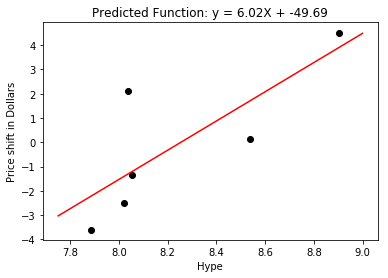

In [661]:
import numpy

X = price_hype_df['hype created']
y = price_hype_df['price change']

X = numpy.array([[i] for i in X])
y = numpy.array([[i] for i in y])

X_train = X
y_train = y


from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Fit regression model to the training set
regr.fit(X_train, y_train)

# Display model parameters
print('Slope = ', regr.coef_[0][0])
print('Intercept = ', regr.intercept_[0])### Step 4: Postprocessing

# Plot outputs
plt.scatter(X_train, y_train,  color='black')
#plt.plot(X_train, y_train, color='red', linewidth=3)
titlestr = 'Predicted Function: y = %.2fX + %.2f' % (regr.coef_[0], regr.intercept_)
plt.title(titlestr)
plt.xlabel('Hype')
plt.ylabel('Price shift in Dollars')

import numpy as np
x = np.linspace(7.75,9,100)
y = 6.02*x - 49.69
plt.plot(x, y, '-r')


### Coefficient of determination: .6142

In [663]:
# Model evaluation`a
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_train, predicted_y)))
print('R-squared = %.4f' % r2_score(y_train, predicted_y))

Root mean squared error = 1.7161
R-squared = 0.6142


In [642]:
def f(x):
    return 6.02*x - 49.69

In [662]:
from sklearn.metrics import r2_score

predicted_y = [f(x) for x in X]

coefficient_of_dermination = r2_score(y_train, predicted_y)
coefficient_of_dermination

0.6142497496063837

In [648]:
coefficient_of_dermination

0.6142497496063837

In [625]:
numTrain = 4
# number of training instances
numInstances = 6
numTest = numInstances - numTrain

X_train = X[:-numTest]
X_test = X[-numTest:]
y_train = y[:-numTest]
y_test = y[-numTest:]

In [626]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

# Create linear regression object
regr = linear_model.LinearRegression()

# Fit regression model to the training set
regr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

Text(0,0.5,'Predicted values for y')

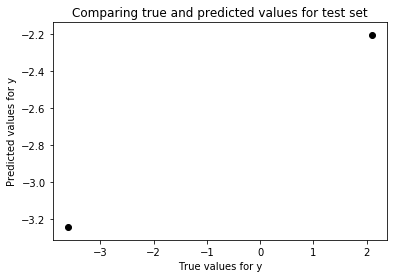

In [630]:
# Apply model to the test set
y_pred_test = regr.predict(X_test)

# Comparing true versus predicted values
plt.scatter(y_test, y_pred_test, color='black')
plt.title('Comparing true and predicted values for test set')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

In [631]:
# Model evaluation
print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print('R-squared = %.4f' % r2_score(y_test, y_pred_test))

Root mean squared error = 3.0510
R-squared = -0.1481


Due to the dearth of data, these results are largely meaningless -- they neither prove or disprove the hypothesis. However, they are useful in that the next step is just gather more data for the next time.

Slope =  6.985810602885158
Intercept =  -58.33935333951343


Text(0,0.5,'y')

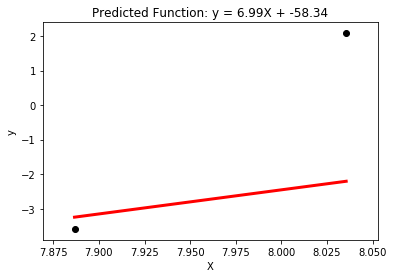

In [633]:
# Display model parameters
print('Slope = ', regr.coef_[0][0])
print('Intercept = ', regr.intercept_[0])### Step 4: Postprocessing

# Plot outputs
plt.scatter(X_test, y_test,  color='black')
plt.plot(X_test, y_pred_test, color='red', linewidth=3)
titlestr = 'Predicted Function: y = %.2fX + %.2f' % (regr.coef_[0], regr.intercept_)
plt.title(titlestr)
plt.xlabel('X')
plt.ylabel('y')

---

# Results using just historical data to predict stock market price fluctuations for Nike from 1980 to 2018

In [651]:
import pandas as pd
%matplotlib inline

data = pd.read_csv('NKE-2.csv', header='infer' )
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,1980-12-02,0.179688,0.183594,0.179688,0.179688,0.000004,100710400
1,1980-12-03,0.177734,0.177734,0.175781,0.175781,0.000004,25177600
2,1980-12-04,0.181641,0.183594,0.181641,0.181641,0.000004,22694400
3,1980-12-05,0.175781,0.175781,0.171875,0.171875,0.000004,7590400
4,1980-12-08,0.164063,0.164063,0.162109,0.162109,0.000003,5414400


[Text(0,0.5,'Closing Price')]

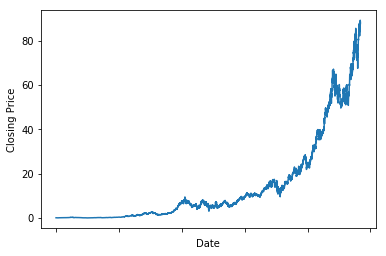

In [652]:
closingPrice = data['Close']
closingPrice.index = data['Date']
ax = closingPrice.plot(kind='line')
ax.set(ylabel='Closing Price')

Date
1980-12-03   -0.003907
1980-12-04    0.005860
1980-12-05   -0.009766
1980-12-08   -0.009766
1980-12-09   -0.003906
dtype: float64

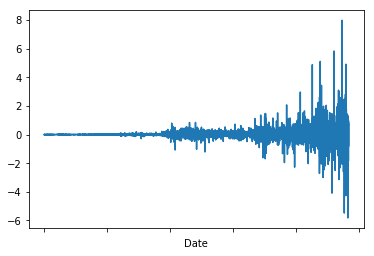

In [653]:
N = closingPrice.shape[0]
Y = pd.Series(closingPrice[1:N].values - closingPrice[:N-1].values, index=closingPrice.index[1:])
Y.plot(kind='line')
Y.head()

In [654]:
N = Y.shape[0]
X = pd.DataFrame( Y[:N-3].values,columns=['t-4'])
X['t-3'] = Y[1:N-2].values
X['t-2'] = Y[2:N-1].values
X['t-1'] = Y[3:N].values
X = X[:-1]
X.index = Y[4:].index
X.head()

,t-4,t-3,t-2,t-1
Date,,,,
1980-12-09,-0.003907,0.005860,-0.009766,-0.009766
1980-12-10,0.005860,-0.009766,-0.009766,-0.003906
1980-12-11,-0.009766,-0.009766,-0.003906,-0.009765
1980-12-12,-0.009766,-0.003906,-0.009765,-0.007813
1980-12-15,-0.003906,-0.009765,-0.007813,0.005859


In [655]:
y = Y[4:]
y.head()

Date
1980-12-09   -0.003906
1980-12-10   -0.009765
1980-12-11   -0.007813
1980-12-12    0.005859
1980-12-15    0.005860
dtype: float64

## Divide model into 90% training, 10% testing

In [656]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=1)

In [657]:
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Create linear regression object
regr = linear_model.LinearRegression()

# Fit regression model to the training set
regr.fit(X_train, y_train)

# Apply model to the test set
y_pred_test = regr.predict(X_test)

print("Root mean squared error = %.4f" % np.sqrt(mean_squared_error(y_test, y_pred_test)))
print("R-square = %.4f" % r2_score(y_test, y_pred_test))
print('Slope Coefficients:', regr.coef_)
print('Intercept:', regr.intercept_)

Root mean squared error = 0.3806
R-square = 0.0044
Slope Coefficients: [-0.07284592  0.01571662 -0.02528144 -0.07886995]
Intercept: 0.010069356420654535


Text(0,0.5,'Predicted values for y')

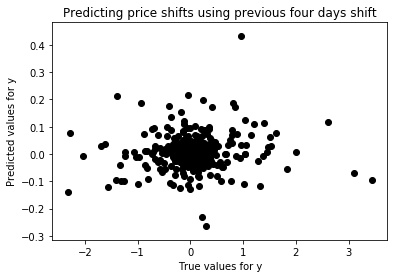

In [659]:
# Apply model to the test set
y_pred_test = regr.predict(X_test)

# Comparing true versus predicted values
plt.scatter(y_test, y_pred_test, color='black')
plt.title('Predicting price shifts using previous four days shift')
plt.xlabel('True values for y')
plt.ylabel('Predicted values for y')

##### This graph confirms that using the last four trading days to predict a price swing is as useful as randomly guessing.
#### Also, ultimately, using previous price fluctuations to predict future ones as proven by the R-Square value of 0.0044. This suggests that future price swings are independent of past ones. 

### Although we have limited data, twitter sentiment analysis data presents a more viable alternative, although more data and resources are required to prove/disprove this hypothesis